In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from ipywidgets import interact, interactive, fixed
import seaborn as sns


# APPLICATIONS OF HIDDEN MARKOV MODELS: PREDICTIVE MAINTENANCE ON TURBOFAN ENGINE DEGREDATION SIMULATION DATASET

In [2]:
dataset_path = 'CMAPSSData/train_FD001.txt'
#TODO: the following command creates a dataframe with NaN collums the sensor21 aka:'s21'
df = pd.read_csv(dataset_path, sep=' ', low_memory=False)
#print(df)

sens_df = df.loc[:,'s1': ]
norm_sens = (sens_df-sens_df.min())/(sens_df.max()-sens_df.min())
df.loc[:,'s1': ] = norm_sens
df = df.dropna(axis=1, how='all')


pivot_df = df.pivot(index='time', columns='unit_number')
sensors = pd.DataFrame(pivot_df.stack().loc[:,'s2':'s21'])
sensors = sensors.unstack()

cycle_till_failure= len(sensors['s2'].index) - np.sum(pd.isnull(sensors['s2']))
ordered_motor_id_indexes = (np.argsort(cycle_till_failure)+1)
MAX_CYCLE = max(cycle_till_failure)

#calculate Remaining Useful Life as cycles
RUL = np.add(-df['time'], cycle_till_failure[df['unit_number']] )
LOG_RUL = np.log(RUL + 1)
df['LOG_RUL'] = LOG_RUL
df['RUL'] = RUL

#repivot the data with the added RUL column to dataframe
pivot_df = df.pivot(index='time', columns='unit_number')
sensors = pd.DataFrame(pivot_df.stack().loc[:,'s2':'s21'])
sensors = sensors.unstack()

units = sensors.stack().stack().unstack('unit_number')
units = units.unstack(1)
#shift the columns so that the last index is the last sensor data before the failure
for column in units.columns.levels[0]:
    units[column] = units[column].shift(MAX_CYCLE - cycle_till_failure[column])
    
units = units.stack(1)

ordered_units = units[ordered_motor_id_indexes]
sensors = ordered_units.stack().unstack(1).unstack('unit_number')
units = ordered_units.unstack(1)




In [3]:
np.mean(cycle_till_failure) #128-362

206.31

In [4]:
def length_normalized_sensors(size):
    l_norm_df = pd.DataFrame(columns = sensors.columns, index = range(1,size+1))
    s_df = None
    for sensor in sensors.columns.levels[0]:
        l_norm_df[sensor] = length_normalized_sensor(size,sensor)
        print(sensor + ' is normalized')
    return l_norm_df


In [5]:
def length_normalized_sensor(n,sensor):
    sense_df = sensors[sensor]
    #cycle_till_failure= len(sense_df.index) - np.sum(pd.isnull(sensors[sensor]))
    pick_df =  sense_df.iloc[0:n,:].copy()      

    for i in range(2,n+1):
        s = pd.Series([])
        for j in range(1,len(sense_df.columns)+1):
            s.loc[j] = (sense_df.loc[int(MAX_CYCLE - cycle_till_failure.loc[j] + cycle_till_failure.loc[j] *i/n),j])
        pick_df.loc[i,:] = s
    return(pick_df)


In [6]:
# pick 100 equally spaced sample for each motor and each sensor from the 
# first sensor reading to the last reading before the failure
sensors100 = length_normalized_sensors(100) 
print('covariance matrix is calculating')
covariance_matrix = df.loc[:,'s2':'RUL'].corr()
print('covariance matrix is calculated')


s2 is normalized
s3 is normalized
s4 is normalized
s6 is normalized
s7 is normalized
s8 is normalized
s9 is normalized
s11 is normalized
s12 is normalized
s13 is normalized
s14 is normalized
s15 is normalized
s17 is normalized
s20 is normalized
s21 is normalized
covariance matrix is calculating
covariance matrix is calculated


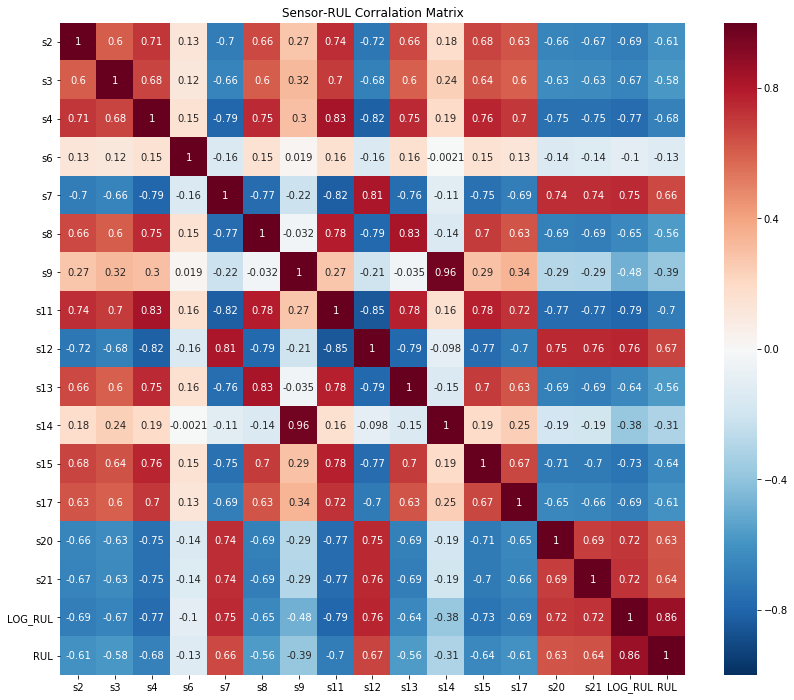

In [7]:
ig, ax = plt.subplots(figsize=(14,12))  
plt.title('Sensor-RUL Corralation Matrix')
sns.heatmap(covariance_matrix, 
        xticklabels=covariance_matrix.columns,
        yticklabels=covariance_matrix.columns,
        center = 0, cmap="RdBu_r", vmin=-1, vmax=1, annot= True)

In [8]:
def unit_plot(unit_id):
    units[unit_id].plot(legend=False,title = 'Sensor Readings for Motor '+str(unit_id) + ' till Failure', figsize=(16,8))
    unit_heat_plot(unit_id)
    
    
def unit_heat_plot(unit_id):
    unit = units[unit_id].copy()
    unit = unit.dropna(axis=0, how='all')
    plt.figure(figsize=(16,6))
    plt.imshow(unit.T,interpolation='nearest', 
       vmin=0, vmax=1,origin='lower',cmap='jet')
    plt.xlabel('cycle')
    plt.ylabel('sensor')
    plt.title('Sensor Readings for Motor '+str(unit_id) + ' till Failure')
    plt.show()
    
interact(unit_plot, unit_id = units.columns.levels[0])

interactive(children=(Dropdown(description='unit_id', options=(39, 91, 70, 57, 58, 24, 8, 65, 90, 77, 93, 27, 98, 45, 19, 36, 13, 29, 28, 74, 23, 37, 12, 60, 63, 87, 3, 62, 14, 35, 99, 61, 80, 40, 6, 85, 4, 32, 44, 1, 55, 30, 38, 18, 21, 53, 34, 42, 50, 26, 68, 79, 33, 100, 9, 66, 22, 97, 15, 43, 71, 16, 76, 73, 52, 51, 72, 88, 47, 82, 49, 41, 89, 10, 75, 25, 59, 48, 78, 20, 31, 81, 11, 46, 54, 94, 7, 84, 5, 56, 17, 86, 95, 64, 2, 83, 67, 96, 92, 69), value=39), Output()), _dom_classes=('widget-interact',))

<function __main__.unit_plot>

In [9]:
def plot(sensor_name):
    sensors[sensor_name].plot(legend=False, title = 'sensor '+sensor_name+' readings per cycle', figsize=(16,5))
    heat_plot(sensor_name)
    sensors100[sensor_name].plot(legend=False, title = 'sensor '+sensor_name+' readings stretched', figsize=(10,5))
    heat_plot_normalized(sensor_name)
    
    
def heat_plot(sensor_name):
    plt.figure(figsize=(16,10))
    plt.imshow(sensors[sensor_name].T,interpolation='nearest', 
       vmin=0, vmax=1,origin='lower',cmap='jet')
    plt.xlabel('cycle')
    plt.ylabel('motor')
    plt.title(sensor_name + ' readings till failure')
    plt.show()
    
    
def heat_plot_normalized(sensor_name):
    plt.figure(figsize=(10,10))
    plt.imshow(sensors100[sensor_name].T,interpolation='nearest', 
           vmin=0, vmax=1,origin='lower',cmap='jet')
    plt.xlabel('normalized time')
    plt.ylabel('motor id')
    plt.title(sensor_name + ' readings till failure')
    plt.show()

    
interact(plot, sensor_name = sensors.columns.levels[0])

interactive(children=(Dropdown(description='sensor_name', options=('s2', 's3', 's4', 's6', 's7', 's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21'), value='s2'), Output()), _dom_classes=('widget-interact',))

<function __main__.plot>